<a href="https://colab.research.google.com/github/armandordorica/Portfolio_Optimization/blob/master/markowitz_portfolio_optimization_master_CLA_LOOP_YFINANCE_PY37.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Markowitz Portfolio Optimizer using Critical Line Algorithm

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/My\ Drive/u\ of\ t/APS\ 1051\ Portfolio\ Optimization/Jupyter\ Notebooks

/content/drive/My Drive/u of t/APS 1051 Portfolio Optimization/Jupyter Notebooks


In [3]:
ls

FixYahoo.ipynb
HarrysProblemLoop_MAINPROGRAM.ipynb
HARRYS_PROBLEM_LOOP.py
markowitz-portfolio-optimization-master.CLA_LOOP.YFINANCE.PY37/
markowitz-portfolio-optimization-master.YFINANCE/


In [4]:
!pip install yfinance

  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=783dc6378cc3354ff27cdc41182677fcb1b71b5c28ed94bbc35204d09212e214
  Stored in directory: /root/.cache/pip/wheels/f9/e3/5b/ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
Successfully built yfinance


In [5]:
!pip install cvxpy

In [7]:
cd markowitz-portfolio-optimization-master.CLA_LOOP.YFINANCE.PY37

/content/drive/My Drive/u of t/APS 1051 Portfolio Optimization/Jupyter Notebooks/markowitz-portfolio-optimization-master.CLA_LOOP.YFINANCE.PY37


In [8]:
ls

CLA_Data.csv  main_CLA_loop_Python37_RUN_THIS.py  StockPrices.csv
CLA_mod.py    __pycache__/
CLA_mod.pyc   README_INSTRUCTIONS.txt


# New Section

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:93: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


returns std= 1.0059317528889093


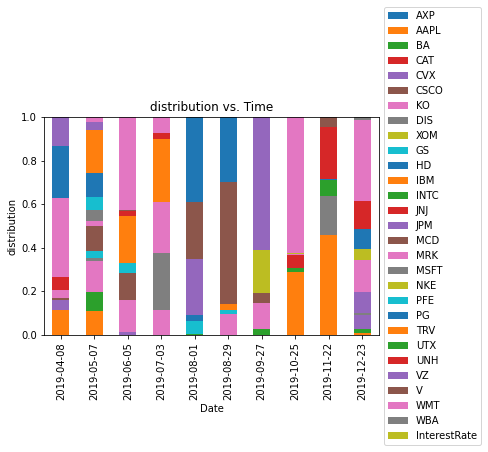

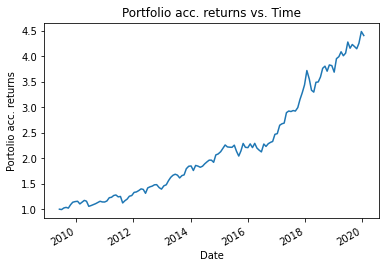

TotaAnnReturn in percent = 31.517226
CAGR in percent = 14.713417
Sharpe Ratio = 2.680000
Sharpe2 Ratio = 1.190000


In [9]:
# -*- coding: utf-8 -*-
"""
Created on Wed Dec 18 08:56:10 2019
Written by Lopez de Prado
This program runs in Python 2.7
Applies Markowitz minimum variance weights and maximum sharpe ratio weights using Critical Line Algorithm
https://dreamix.eu/blog/webothers/timeout-function-in-python-3
"""

import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import CLA_mod

def plot2D(x,y,xLabel='',yLabel='',title='',pathChart=None):
    import matplotlib.pyplot as mpl
    fig=mpl.figure()
    ax=fig.add_subplot(1,1,1) #one row, one column, first plot
    ax.plot(x,y,color='blue')
    ax.set_xlabel(xLabel)
    ax.set_ylabel(yLabel,rotation=90)
    mpl.xticks(rotation='vertical')
    mpl.title(title)
    if pathChart==None:
        mpl.show()
    else:
        mpl.savefig(pathChart)
    mpl.clf() # reset pylab
    return

#################################################################################
## Read stock prices data from csv file
#StockList = ['AAPL','IBM','MSFT','GOOG','QCOM']		# Stock ticker names
#price = pd.read_csv('StockPrices.csv')
#price["Date"]=pd.to_datetime(price["Date"])
#price.index = price["Date"]
#price = price.drop('Date',1)
##################################################################################

pd.core.common.is_list_like = pd.api.types.is_list_like #datareader problem probably fixed in next version of datareader
from pandas_datareader import data as pdr
import datetime as dt
import yfinance as yf
yf.pdr_override() # <== that's all it takes :-)
#start, end = dt.datetime(2000, 1, 3), dt.datetime(2014, 12, 31)
#StockList = ['AAPL','IBM','MSFT','GOOG','QCOM']		# Stock ticker names

start, end = dt.datetime(2009, 1, 30), dt.datetime(2020, 1, 30)
StockList = ['AXP', 'AAPL', 'BA','CAT','CVX','CSCO','KO','DIS','XOM','GS', 'HD', 'IBM','INTC','JNJ','JPM','MCD','MRK','MSFT','NKE','PFE', 'PG', 'TRV','UTX','UNH', 'VZ','V','WMT','WBA']

price = pd.DataFrame()
for ticker in StockList:
    price[ticker]  = pdr.get_data_yahoo(ticker, start=start, end=end).loc[:,'Close'] #breaks if 'Adj Close' prices are used


interest_rate = 0.02/12		# Fixed interest rate
cash = .001
# Specify number of days to shift
shift = 20 #monthly rebalancing and return period
lookback = 60
T = 12 #months in a year
# Compute returns over the time period specified by shift
shift_returns = price/price.shift(shift) - 1

NumStocks = len(StockList)

# Compute mean
shift_returns_mean_ewm = shift_returns.ewm(span=lookback).mean()
shift_returns_mean_sma = shift_returns.rolling(window=lookback).mean()

#covariance matrix construction
arr = np.zeros(shift_returns.shape[0], dtype=object)
for i in range(0, shift_returns.shape[0]-shift): 
    arr[i+shift]= shift_returns.iloc[i:i+shift].cov().fillna(value=0).to_numpy() 

shift_returns_copy = shift_returns.copy(deep=True)
shift_returns_copy["covmatrix"] = arr

#lower and upper boundaries for CLA solver
LB = np.zeros((NumStocks,1))
UB = np.ones((NumStocks,1))

# Variable Initialization
start_date = '2009-06-01'
index = shift_returns.index
start_index = index.get_loc(start_date)
end_date = index[-1]
end_index = index.get_loc(end_date)
date_index_iter = start_index
StockList.append('InterestRate') ############################ ADD INTEREST RATE
distribution = DataFrame(index=StockList)
returns = Series(index=index)

# Start Value
total_value = 1.0
returns[index[date_index_iter]] = total_value

while date_index_iter + shift < end_index:
    date = index[date_index_iter]
    mean_cla = shift_returns_mean_ewm.loc[date].to_numpy().reshape(NumStocks,1)
    covar_cla = shift_returns_copy["covmatrix"].loc[date]
    cla=CLA_mod.CLA(mean_cla,covar_cla,LB,UB)
    br=0
    cla.solve(br)
    #Using Maximum Sharpe Ratio Weights
    if br == 0:
        sr,w_sr=cla.getMaxSR()
    else:
        sr=sr
        w_sr=w_sr
        
    w_sr = (1-cash)*w_sr
    w_sr = np.append(w_sr, cash)
    portfolio_alloc = w_sr

#    #using Minimum Variance Weights
#    mv,w_mv=cla.getMinVar()
#    w_mv = (1-cash)*w_mv
#    w_mv = np.append(w_mv, cash)
#    portfolio_alloc = w_mv

    distribution[date.strftime('%Y-%m-%d')] = portfolio_alloc
    
    # Calculating portfolio return
    date2 = index[date_index_iter+shift]
    temp1 = price.loc[date2]/price.loc[date]
    temp1.loc[StockList[-1]] = interest_rate+1 #StockList[-1] is "InterestRate"
    
    temp2 = Series(np.array(portfolio_alloc.ravel()).reshape(len(portfolio_alloc)),index=StockList)
    total_value = np.sum(total_value*temp2*temp1)
    
	# Increment Date
    date_index_iter += shift
    returns[index[date_index_iter]] = total_value

# Remove dates that there are no trades from returns
returns = returns[np.isfinite(returns)]


# Plot portfolio allocation of last 10 periods
ax = distribution.T.iloc[-10:].plot(kind='bar',stacked=True)
plt.ylim([0,1])
plt.xlabel('Date')
plt.ylabel('distribution')
plt.title('distribution vs. Time')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.savefig('allocation.png')

"""
# Plot stock prices and shifted returns
fig, axes = plt.subplots(nrows=2,ncols=1)
price.plot(ax=axes[0])
shift_returns.plot(ax=axes[1])
axes[0].set_title('Stock Prices')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Price')
axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes[1].set_title(str(shift)+ ' Day Shift returns')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('returns ' + str(shift) + ' Days Apart')
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.savefig('stocks.png', pad_inches=1)
fig.tight_layout()
plt.show()
"""

# Plot portfolio returns vs. time
plt.figure()
returns.plot()
plt.xlabel('Date')
plt.ylabel('Portolio acc. returns')
plt.title('Portfolio acc. returns vs. Time')
# plt.savefig('returns.png')
print ('returns std=', returns.std())

plt.show()

df = pd.DataFrame(returns, index=returns.index, columns=['I'])
df["returns"]=(df.I-df.I.shift(1))/df.I.shift(1)
start_date = df.iloc[0].name
end_date = df.iloc[-1].name
days_per_month = float(30) #since .days (see below) is calendar days, need to use 30 here
months = float((end_date - start_date).days/days_per_month )
periods = float(12) #12 months in a year
start_val = float(df['I'].iat[0])
end_val = float(df['I'].iat[-1])
years = float(months)/float(periods)

CAGR = ((((end_val/start_val)**(1/years)))-1)
TotaAnnReturn = (end_val-start_val)/(start_val)/years

try:
    sharpe =  TotaAnnReturn/( (df.returns.std()) * np.sqrt(periods))
except ZeroDivisionError:
    sharpe = 0.0

#this is a more conservataive estimate:
try:
    sharpe2 =  (df.returns.mean()/df.returns.std()) * np.sqrt(periods)
except ZeroDivisionError:
    sharpe2 = 0.0

print ("TotaAnnReturn in percent = %f" %(TotaAnnReturn*100))
print ("CAGR in percent = %f" %(CAGR*100))
print ("Sharpe Ratio = %f" %(round(sharpe,2)))
print ("Sharpe2 Ratio = %f" %(round(sharpe2,2)))


##Annualized Efficient Frontier based on latest month
#mu,sigma,weights=cla.efFrontier(100)
#mu = np.power((1 + np.array(mu)),T) - 1
#sigma=np.array(sigma)*np.sqrt(T)
#plot2D(sigma,mu,'Annualized Risk','Annualized Expected Excess Return in Frac','CLA-derived Efficient Frontier in Frac')

In [ ]:
ls

LICENSE               posdef.py                Report.pdf
main_mod_RUN_THIS.py  __pycache__/             sample_data/
markowitz_mod.py      README_INSTRUCTIONS.txt  StockPrices.csv
markowitz_mod.pyc     README.md
